# Bulk RNA-seq to Single RNA-seq

Bulk2Single is used for bulk RNA-seq deconvolution. We extracted the beta-VAE part of the Bulk2Space algorithm and constructed an algorithm that can deconvolute from Bulk RNA-seq to Single Cell RNA-seq. In addition, we have redesigned the input and output of the data so that it can be more compatible with the analysis conventions in the Python environment.

Paper: [De novo analysis of bulk RNA-seq data at spatially resolved single-cell resolution](https://www.nature.com/articles/s41467-022-34271-z)

Code: https://github.com/ZJUFanLab/bulk2space

Colab_Reproducibility：https://colab.research.google.com/drive/1He71hAyeAv1DHQyXUlxtoJ4QvwZwW7I0?usp=sharing

This tutorial walks through how to read, set-up and train the model from bulk RNA-seq and reference scRNA-seq data. We use the pdac datasets as example

In [2]:
import scanpy as sc
import omicverse as ov
import matplotlib.pyplot as plt
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


## loading data

For illustration, we apply differential kinetic analysis to dentate gyrus neurogenesis, which comprises multiple heterogeneous subpopulations.

We utilized single-cell RNA-seq data (GEO accession: GSE95753) obtained from the dentate gyrus of the hippocampus in rats, along with bulk RNA-seq data (GEO accession: GSE74985). 

In [3]:
bulk_data=ov.read('data/GSE74985_mergedCount.txt.gz',index_col=0)
bulk_data=ov.bulk.Matrix_ID_mapping(bulk_data,'genesets/pair_GRCm39.tsv')
bulk_data.head()

,dg_d_1,dg_d_2,dg_d_3,dg_v_1,dg_v_2,dg_v_3,ca4_1,ca4_2,ca4_3,ca3_d_1,...,ca3_v_3,ca2_1,ca2_2,ca2_3,ca1_d_1,ca1_d_2,ca1_d_3,ca1_v_1,ca1_v_2,ca1_v_3
Gm7541,0,0,0,14,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Mrln,0,0,0,0,0,4,0,1,0,2,...,0,0,0,0,0,0,0,0,0,1
Ltb,0,0,0,0,0,0,0,0,0,2,...,0,0,0,6,0,0,0,0,0,0
Gps1,456,415,146,271,237,365,1401,1394,988,586,...,1043,685,489,489,821,953,720,247,140,260
Dab2,0,0,0,0,0,0,3,5,27,0,...,30,0,0,0,1,0,0,0,1,0


In [4]:
import anndata
import scvelo as scv
single_data=scv.datasets.dentategyrus()
single_data

Global seed set to 0


AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Cell Fraction calculation

We can now set up the Bulk2Single object, which will ensure everything the model needs is in place for training. We need to specify the cell type of the scRNA-seq to deconvolute the Bulk RNA-seq. And specify the number of marker genes for each cell type for training.

if you set `gpu`=-1, it will use CPU to configure the VAE model.

In [9]:
model=ov.bulk2single.Bulk2Single(bulk_data=bulk_data,single_data=single_data,
                celltype_key='clusters',bulk_group=['dg_d_1','dg_d_2','dg_d_3'],
                 top_marker_num=200,ratio_num=1,gpu=0)

Here, we improved the estimation of cell proportions in Bulk2space, and we eliminated the regression estimation used by the original authors, which typically results in a large bias in proportions, as confirmed in our analysis. We introduced TAPE, This model is able to accurately deconvolve bulk RNA-seq data into cell fractions and predict cell-type-specific gene expression at cell- type level based on scRNA-seq data.

Paper: [Deep autoencoder for interpretable tissue-adaptive deconvolution and cell-type-specific gene analysis](https://doi.org/10.1038/s41467-022-34550-9)

Code: https://github.com/poseidonchan/TAPE

Reading single-cell dataset, this may take 1 min
Reading dataset is done
Normalizing raw single cell data with scanpy.pp.normalize_total
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
You set sparse as True, some cell's fraction will be zero, the probability is 0.5
Sampling cells to compose pseudo-bulk data


5000it [00:18, 271.97it/s]


Sampling is done
Reading training data
Reading is done
Reading test data
Reading test data is done
Using counts data to train model
Cutting variance...
Finding intersected genes...
Intersected gene number is  12227
Scaling...


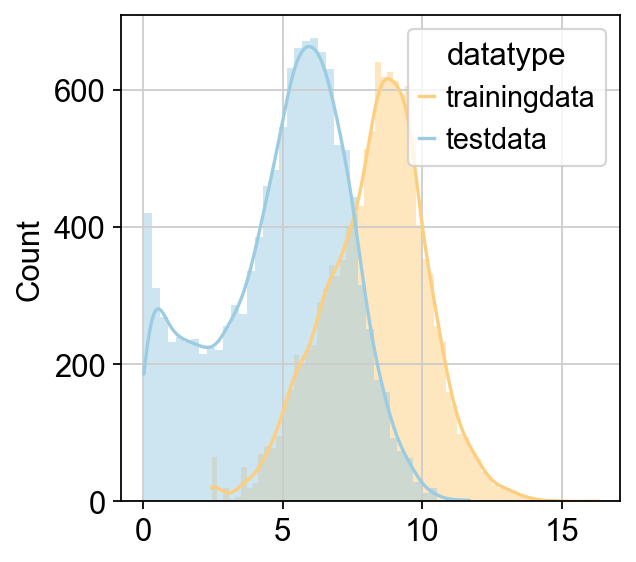

Using minmax scaler...


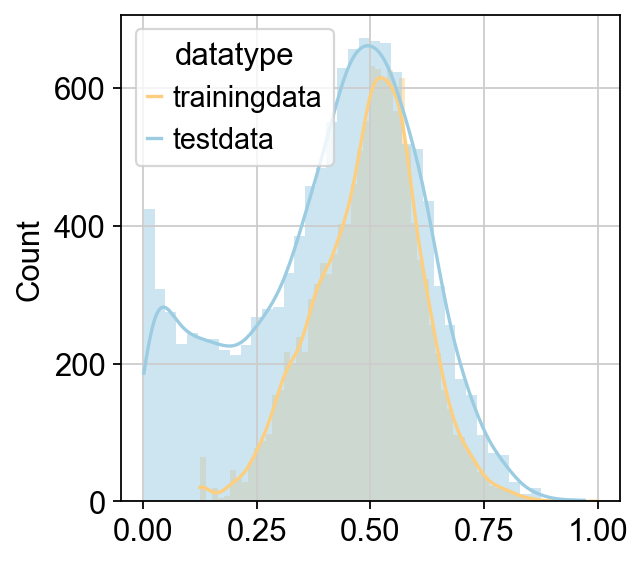

training data shape is  (5000, 12227) 
test data shape is  (24, 12227)
train model256 now


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


train model512 now


100%|██████████| 128/128 [00:35<00:00,  3.61it/s]


train model1024 now


100%|██████████| 128/128 [00:40<00:00,  3.16it/s]


Training of Scaden is done
Predicted Total Cell Num: 2457.2684493806505


In [10]:
CellFractionPrediction=model.predicted_fraction()

In [11]:
CellFractionPrediction.head()

,Astrocytes,Cajal Retzius,Cck-Tox,Endothelial,GABA,Granule immature,Granule mature,Microglia,Mossy,Neuroblast,OL,OPC,Radial Glia-like,nIPC
dg_d_1,0.004544,0.006886,0.007911,0.003683,0.018271,0.516428,0.382375,0.006950,0.024387,0.006066,0.006472,0.005578,0.003089,0.007359
dg_d_2,0.005687,0.005695,0.006550,0.004516,0.013343,0.463494,0.429194,0.009259,0.033580,0.008134,0.005424,0.007804,0.002305,0.005016
dg_d_3,0.005510,0.006490,0.006559,0.004048,0.012119,0.507005,0.399984,0.008632,0.024209,0.006444,0.005619,0.005645,0.002442,0.005295
dg_v_1,0.003124,0.005557,0.007536,0.002828,0.029218,0.541319,0.307726,0.004685,0.062974,0.009509,0.006627,0.011910,0.001986,0.005001
dg_v_2,0.003997,0.006253,0.008593,0.003638,0.032814,0.533492,0.307392,0.004409,0.056683,0.013278,0.007369,0.013649,0.002328,0.006105


We used stacked histograms to visualize the cellular proportions for each of the samples

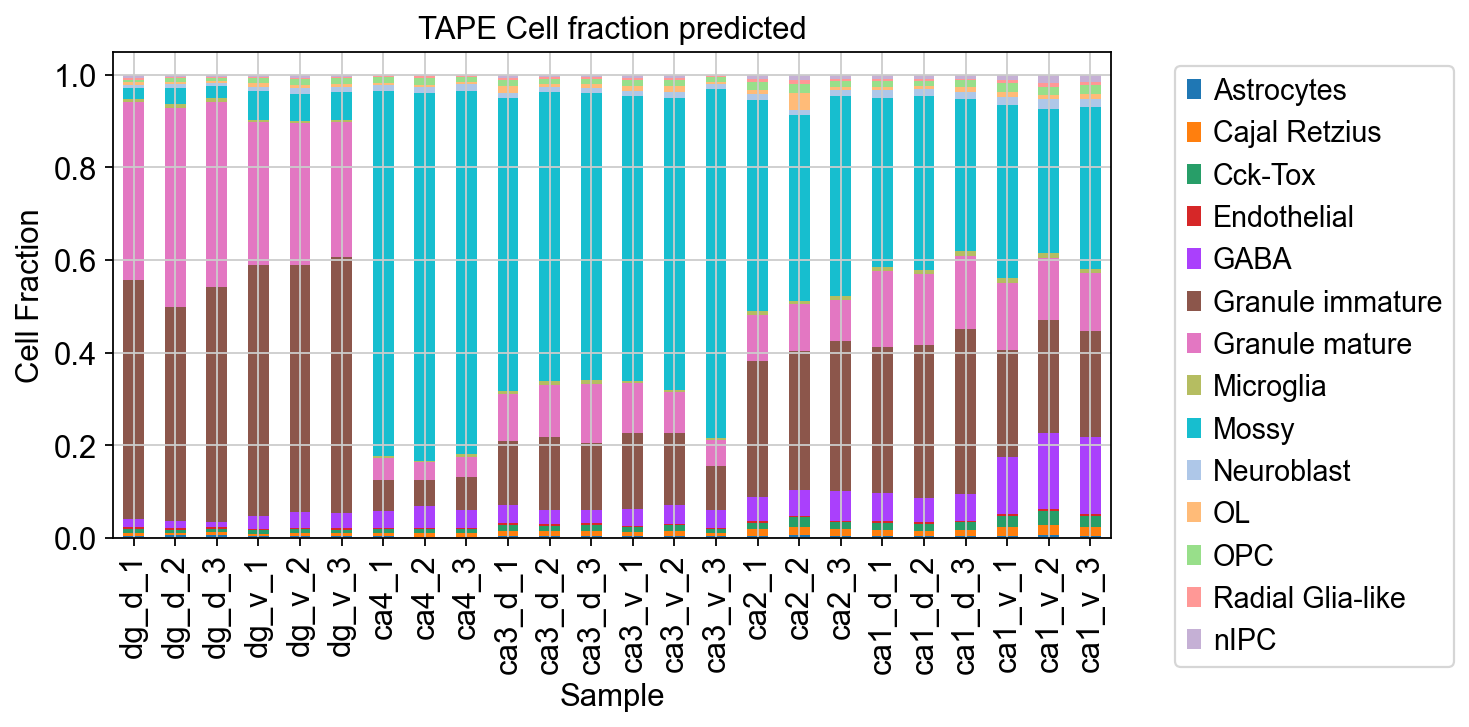

In [12]:
ax = CellFractionPrediction.plot(kind='bar', stacked=True, figsize=(8, 4))
ax.set_xlabel('Sample')
ax.set_ylabel('Cell Fraction')
ax.set_title('TAPE Cell fraction predicted')
plt.legend(bbox_to_anchor=(1.05, 1),ncol=1,)
plt.show()

## Bulk2single training

### Preprocess the single-cell RNA-seq and bulk RNA-seq

After obtaining the cell proportions for each sample, we also wanted to obtain single-cell data for the samples, where we used beta-VAE to predict the cells in the Bulk, and we first preprocessed the data.

The groups are ['dg_d_1', 'dg_d_2', 'dg_d_3'], which represent the sample DG granule cell

In [8]:
model.bulk_preprocess_lazy()
model.single_preprocess_lazy()
model.prepare_input()

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


### Trainging the VAE model

We started training the VAE model to generate single-cell data, a process that took roughly 3 hours on the CPU and only 10 minutes on the GPU.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    the default max epochs is set to 3500, but in practice Bulk2Single stops early once the model converges, which rarely requires that many, especially for large datasets.(We can set the `patience` to control the stop steps)
  </p>
</div>

In [9]:
vae_net=model.train(
    batch_size=512,
    learning_rate=1e-4,
    hidden_size=256,
    epoch_num=3500,
    vae_save_dir='data/bulk2single/save_model',
    vae_save_name='dg_vae',
    generate_save_dir='data/bulk2single/output',
    generate_save_name='dg')

...begin vae training


Train Epoch: 3499: 100%|██████████| 3500/3500 [12:03<00:00,  4.84it/s, loss=0.8554, min_loss=0.8544]


min loss = 0.8544222712516785
...vae training done!
...save trained vae in data/bulk2single/save_model/dg_vae.pth.


We can plot the vae loss use a simple method named `plot_loss`

(<Figure size 320x320 with 1 Axes>,
 <AxesSubplot: title={'center': 'Beta-VAE'}, xlabel='Epochs', ylabel='Loss'>)

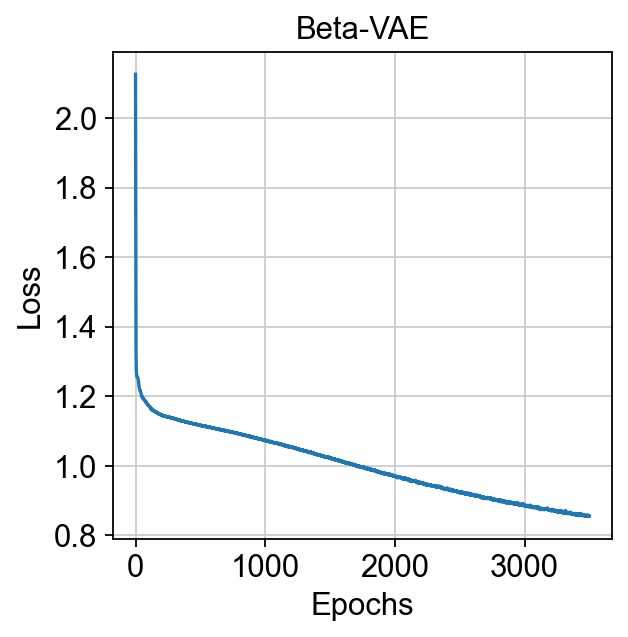

In [10]:
model.plot_loss()

We can also load our previously trained model directly

In [10]:
#model.load_fraction('dg_vae_cell_target_num.pkl')
#model.bulk_preprocess_lazy()
#model.single_preprocess_lazy()
#model.prepare_input()
vae_net=model.load('data/bulk2single/save_model/dg_vae.pth')

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data
loading model from data/bulk2single/save_model/dg_vae.pth


Now, we can generate an Bulk2Single deconvoluted scRNA-seq matrix from our model.

In [11]:
generate_adata=model.generate()
generate_adata

...generating


generating: 100%|██████████| 4907/4907 [00:00<00:00, 17615.06it/s]

generated done!


AnnData object with n_obs × n_vars = 4907 × 12953
    obs: 'clusters'

There is a lot of noise in our directly generated single-cell data, and we need to filter the noisy cells.

In [13]:
generate_adata=model.filtered(generate_adata,leiden_size=25)
generate_adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    on highly variable genes
    with n_comps=100
    finished (0:00:02)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 129 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
The filter leiden is  ['22', '43', '38', '39', '40', '41', '42', '45', '44', '46', '47', '48', '36', '37', '30', '35', '28', '23', '34', '25', '26', '27', '24', '2

View of AnnData object with n_obs × n_vars = 3591 × 1529
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## visualizing and analyzing the correlation

We need to test the characteristics of the generated single cell RNA-seq and the correlation with the reference scRNA-seq. Here, we calculated the correlation between the cell type of the reference scRNA-seq and the cell type of the generated scRNA-seq using the Pearson coefficient using the cell type-specific marker of the reference scRNA-seq as an anchor point.

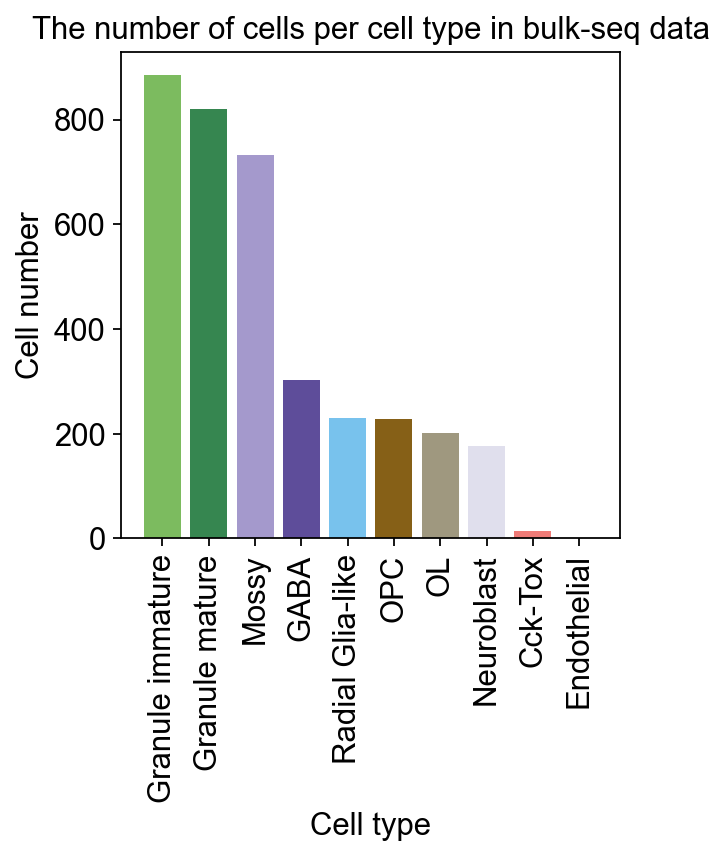

In [14]:
ov.bulk2single.bulk2single_plot_cellprop(generate_adata,celltype_key='clusters')
plt.grid(False)

It is very easy for us to compare the proportion of cells between the reference scRNA-seq and generate scRNA-seq

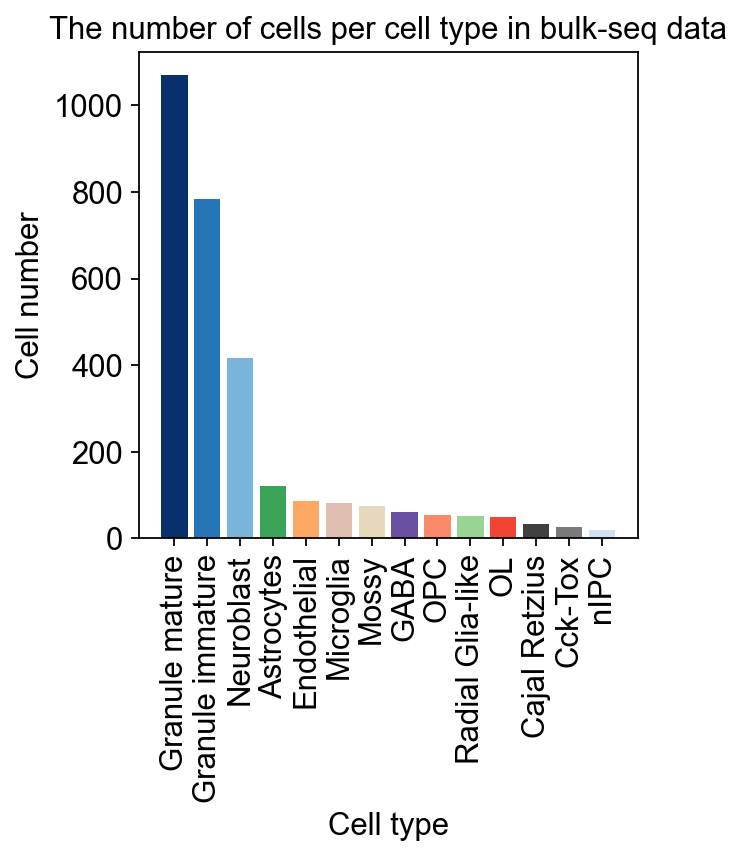

In [15]:
ov.bulk2single.bulk2single_plot_cellprop(single_data,celltype_key='clusters')
plt.grid(False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


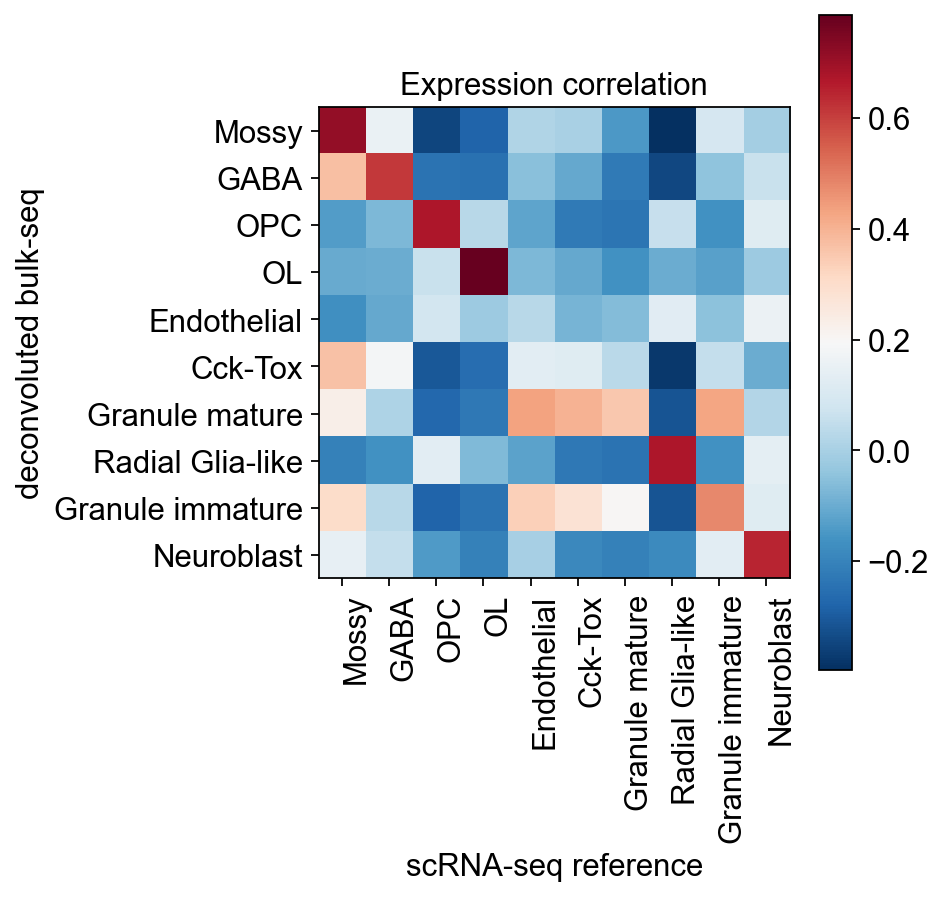

In [16]:
ov.bulk2single.bulk2single_plot_correlation(single_data,generate_adata,celltype_key='clusters')
plt.grid(False)

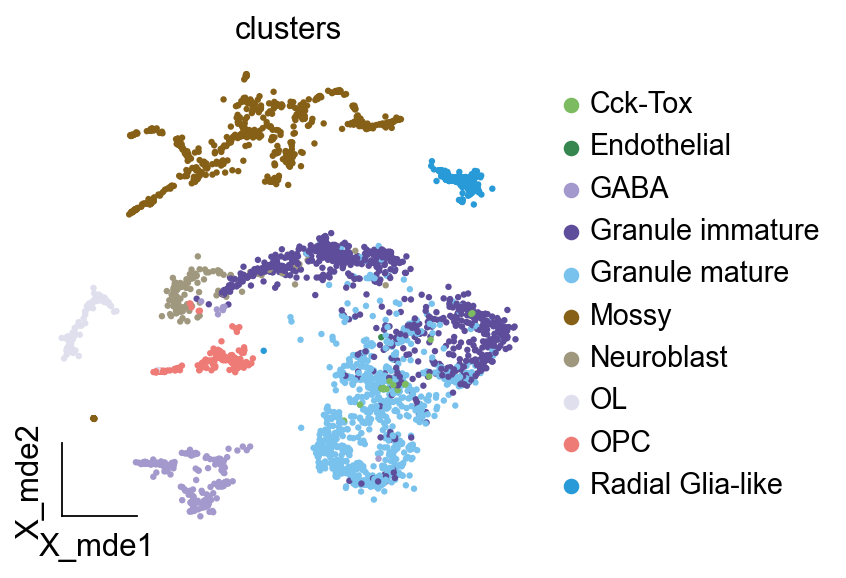

In [18]:
import scanpy as sc
generate_adata.obsm["X_mde"] = ov.utils.mde(generate_adata.obsm["X_pca"])
ov.utils.embedding(generate_adata,basis='X_mde',color=['clusters'],wspace=0.4,
          palette=ov.utils.pyomic_palette(),frameon='small')